# Aspect-Based Sentiment Analysis: Method Comparison

This notebook demonstrates and compares three different approaches to ABSA:
1. **Lexicon-Based** (spaCy + VADER)
2. **Transformer-Based** (DeBERTa fine-tuned for ABSA)
3. **LLM-Based** (Local LLM via Ollama)

## Setup

In [44]:
import sys
import os
sys.path.insert(0, os.path.abspath(".."))

import json
import time
import pandas as pd
import matplotlib.pyplot as plt
from typing import List, Dict
from src import LexiconABSA, ML_ABSA, LLMABSA, AspectSentiment

with open('../data/amazon_dog_food_reviews.json', 'r') as f:
    test_data = json.load(f)

print("Setup complete")
print(f"Loaded {len(test_data['simple_cases'])} simple cases")
print(f"Loaded {len(test_data['complex_cases'])} complex cases")
print(f"Loaded {len(test_data['edge_cases'])} edge cases")

Setup complete
Loaded 10 simple cases
Loaded 10 complex cases
Loaded 10 edge cases


## 1. Initialize All Three Analyzers

In [45]:
print("Initializing analyzers...")

lexicon_analyzer = LexiconABSA()
print("Lexicon-based analyzer ready")

ml_analyzer = ML_ABSA()
print("Transformer-based analyzer ready")

try:
    llm_analyzer = LLMABSA(model="gemma3:1b")
    print("LLM-based analyzer ready")
    has_ollama = True
except Exception as e:
    print(f"LLM analyzer unavailable: {e}")
    has_ollama = False

Initializing analyzers...
Lexicon-based analyzer ready


Device set to use cuda:0


Transformer-based analyzer ready
LLM-based analyzer ready


## 2. Simple Examples: Side-by-Side Comparison

In [46]:
def format_results(results: List[AspectSentiment]) -> str:
    """Format results for display"""
    if not results:
        return "  (no aspects found)"
    lines = []
    for r in results:
        lines.append(f"  • {r.aspect}: {r.sentiment.upper()} (conf: {r.confidence:.2f})")
    return "\n".join(lines)

def compare_methods(text: str, expected=None):
    """Compare all three methods on a single text"""
    print(f"\n{'='*80}")
    print(f"INPUT: \"{text}\"")
    if expected:
        print(f"EXPECTED: {expected}")
    print(f"{'='*80}\n")    
    
    # Lexicon-based
    print("[1] LEXICON-BASED (spaCy + VADER):")
    lex_results = lexicon_analyzer.analyze(text)
    print(format_results(lex_results))
    
    # Transformer-based
    print("\n[2] TRANSFORMER-BASED (DeBERTa):")
    ml_results = ml_analyzer.analyze(text)
    print(format_results(ml_results))
    
    # LLM-based
    if has_ollama:
        print("\n[3] LLM-BASED (Gemma 3):")
        llm_results = llm_analyzer.analyze(text)
        print(format_results(llm_results))
    
    return lex_results, ml_results, llm_results if has_ollama else None

## Example 1: Simple Positive

In [47]:
compare_methods("Best dog food ever")


INPUT: "Best dog food ever"

[1] LEXICON-BASED (spaCy + VADER):
  • Best dog food: POSITIVE (conf: 1.00)
  • dog: POSITIVE (conf: 1.00)
  • food: POSITIVE (conf: 1.00)

[2] TRANSFORMER-BASED (DeBERTa):
  • Best dog food: POSITIVE (conf: 0.98)
  • dog: POSITIVE (conf: 0.99)
  • food: POSITIVE (conf: 0.89)

[3] LLM-BASED (Gemma 3):
  • dog food: POSITIVE (conf: 0.99)


([AspectSentiment(aspect='Best dog food', sentiment='positive', confidence=0.9999984298972682, text_span=(0, 13)),
  AspectSentiment(aspect='dog', sentiment='positive', confidence=0.9999984298972682, text_span=(5, 8)),
  AspectSentiment(aspect='food', sentiment='positive', confidence=0.9999984298972682, text_span=(9, 13))],
 [AspectSentiment(aspect='Best dog food', sentiment='positive', confidence=0.9776538014411926, text_span=(0, 13)),
  AspectSentiment(aspect='dog', sentiment='positive', confidence=0.9892555475234985, text_span=(5, 8)),
  AspectSentiment(aspect='food', sentiment='positive', confidence=0.8929969668388367, text_span=(9, 13))],
 [AspectSentiment(aspect='dog food', sentiment='positive', confidence=0.99, text_span=None)])

### Example 2: Simple Negative  

In [48]:
compare_methods("Tried to change over to this brand, and my dog just doesn't like it and won't eat it.")


INPUT: "Tried to change over to this brand, and my dog just doesn't like it and won't eat it."

[1] LEXICON-BASED (spaCy + VADER):
  • this brand: NEUTRAL (conf: 1.00)
  • my dog: NEGATIVE (conf: 1.00)
  • it: NEGATIVE (conf: 1.00)
  • brand: NEGATIVE (conf: 0.28)
  • dog: NEGATIVE (conf: 1.00)

[2] TRANSFORMER-BASED (DeBERTa):
  • this brand: NEGATIVE (conf: 0.99)
  • my dog: NEGATIVE (conf: 0.99)
  • it: NEGATIVE (conf: 0.97)
  • brand: NEGATIVE (conf: 0.99)
  • dog: NEGATIVE (conf: 0.99)

[3] LLM-BASED (Gemma 3):
  • brand: NEGATIVE (conf: 0.97)
  • dog: NEGATIVE (conf: 0.99)


([AspectSentiment(aspect='this brand', sentiment='neutral', confidence=1.0, text_span=(24, 34)),
  AspectSentiment(aspect='my dog', sentiment='negative', confidence=0.9999972314583847, text_span=(40, 46)),
  AspectSentiment(aspect='it', sentiment='negative', confidence=0.9999972314583847, text_span=(65, 67)),
  AspectSentiment(aspect='brand', sentiment='negative', confidence=0.2755, text_span=(29, 34)),
  AspectSentiment(aspect='dog', sentiment='negative', confidence=0.9999972314583847, text_span=(43, 46))],
 [AspectSentiment(aspect='this brand', sentiment='negative', confidence=0.9936448335647583, text_span=(24, 34)),
  AspectSentiment(aspect='my dog', sentiment='negative', confidence=0.9934008717536926, text_span=(40, 46)),
  AspectSentiment(aspect='it', sentiment='negative', confidence=0.9707241654396057, text_span=(65, 67)),
  AspectSentiment(aspect='brand', sentiment='negative', confidence=0.987380862236023, text_span=(29, 34)),
  AspectSentiment(aspect='dog', sentiment='negative'

### Example 3: Complex Multi-Aspect with Mixed Sentiment

In [49]:
compare_methods("My pup likes this food. The problem is ....The best by or expiration date was not present and there was a small hole in the bag so I don't know the quality so I threw it out and bought a bag from my pet store. Very disappointing and expensive.")


INPUT: "My pup likes this food. The problem is ....The best by or expiration date was not present and there was a small hole in the bag so I don't know the quality so I threw it out and bought a bag from my pet store. Very disappointing and expensive."

[1] LEXICON-BASED (spaCy + VADER):
  • My pup: POSITIVE (conf: 1.00)
  • this food: POSITIVE (conf: 1.00)
  • The problem: POSITIVE (conf: 0.64)
  • a small hole: NEUTRAL (conf: 1.00)
  • the bag: NEUTRAL (conf: 1.00)
  • I: NEUTRAL (conf: 1.00)
  • the quality: NEUTRAL (conf: 1.00)
  • it: NEUTRAL (conf: 1.00)
  • a bag: NEUTRAL (conf: 1.00)
  • my pet store: NEGATIVE (conf: 1.00)

[2] TRANSFORMER-BASED (DeBERTa):
  • My pup: POSITIVE (conf: 0.51)
  • this food: POSITIVE (conf: 0.99)
  • The problem: NEGATIVE (conf: 0.95)
  • a small hole: NEGATIVE (conf: 0.99)
  • the bag: NEGATIVE (conf: 0.99)
  • I: NEGATIVE (conf: 0.89)
  • the quality: NEGATIVE (conf: 0.99)
  • it: NEGATIVE (conf: 0.92)
  • a bag: NEGATIVE (conf: 0.95)
  • my pet

([AspectSentiment(aspect='My pup', sentiment='positive', confidence=0.9999976275263879, text_span=(0, 6)),
  AspectSentiment(aspect='this food', sentiment='positive', confidence=0.9999976275263879, text_span=(13, 22)),
  AspectSentiment(aspect='The problem', sentiment='positive', confidence=0.6369, text_span=(24, 35)),
  AspectSentiment(aspect='a small hole', sentiment='neutral', confidence=1.0, text_span=(104, 116)),
  AspectSentiment(aspect='the bag', sentiment='neutral', confidence=1.0, text_span=(120, 127)),
  AspectSentiment(aspect='I', sentiment='neutral', confidence=1.0, text_span=(131, 132)),
  AspectSentiment(aspect='the quality', sentiment='neutral', confidence=1.0, text_span=(144, 155)),
  AspectSentiment(aspect='it', sentiment='neutral', confidence=1.0, text_span=(167, 169)),
  AspectSentiment(aspect='a bag', sentiment='neutral', confidence=1.0, text_span=(185, 190)),
  AspectSentiment(aspect='my pet store', sentiment='negative', confidence=0.9999979753027429, text_span=(19

### Example 4: Edge Case - Sarcasm

In [50]:
compare_methods("Haven't heard any complaints from my dog so I guess it's delicious.")


INPUT: "Haven't heard any complaints from my dog so I guess it's delicious."

[1] LEXICON-BASED (spaCy + VADER):
  • any complaints: NEUTRAL (conf: 1.00)
  • my dog: NEUTRAL (conf: 1.00)
  • I: NEUTRAL (conf: 1.00)
  • it: POSITIVE (conf: 1.00)
  • complaints: NEUTRAL (conf: 1.00)
  • dog: NEUTRAL (conf: 1.00)

[2] TRANSFORMER-BASED (DeBERTa):
  • any complaints: NEUTRAL (conf: 0.66)
  • my dog: NEUTRAL (conf: 0.96)
  • I: POSITIVE (conf: 0.86)
  • it: POSITIVE (conf: 0.97)
  • complaints: NEGATIVE (conf: 0.79)
  • dog: NEUTRAL (conf: 0.97)

[3] LLM-BASED (Gemma 3):
  • dog: POSITIVE (conf: 0.97)
  • food: POSITIVE (conf: 0.90)


([AspectSentiment(aspect='any complaints', sentiment='neutral', confidence=1.0, text_span=(14, 28)),
  AspectSentiment(aspect='my dog', sentiment='neutral', confidence=1.0, text_span=(34, 40)),
  AspectSentiment(aspect='I', sentiment='neutral', confidence=1.0, text_span=(44, 45)),
  AspectSentiment(aspect='it', sentiment='positive', confidence=0.9999982514456173, text_span=(52, 54)),
  AspectSentiment(aspect='complaints', sentiment='neutral', confidence=1.0, text_span=(18, 28)),
  AspectSentiment(aspect='dog', sentiment='neutral', confidence=1.0, text_span=(37, 40))],
 [AspectSentiment(aspect='any complaints', sentiment='neutral', confidence=0.6627292037010193, text_span=(14, 28)),
  AspectSentiment(aspect='my dog', sentiment='neutral', confidence=0.9576848745346069, text_span=(34, 40)),
  AspectSentiment(aspect='I', sentiment='positive', confidence=0.8577613234519958, text_span=(44, 45)),
  AspectSentiment(aspect='it', sentiment='positive', confidence=0.969727098941803, text_span=(52,

## 3. Batch Testing on All Sample Categories

In [51]:
def evaluate_on_category(category_name: str, samples: List[Dict]):
    """Evaluate all methods on a category of samples"""
    print(f"\n{'#'*80}")
    print(f"CATEGORY: {category_name.upper().replace('_', ' ')}")
    print(f"{'#'*80}\n")
    
    results = []
    
    for i, sample in enumerate(samples, 1):
        text = sample['text']
        note = sample.get('note', None)  # Get note if present (for edge cases)
        
        if note:
            print(f"\n[Note: {note}]")
        
        lex, ml, llm = compare_methods(text, expected=None)
        
        results.append({
            'text': text,
            'note': note,
            'lexicon': lex,
            'ml': ml,
            'llm': llm
        })
    
    return results

# Run on each category
all_results = {}
for category, samples in test_data.items():
    all_results[category] = evaluate_on_category(category, samples)


################################################################################
CATEGORY: SIMPLE CASES
################################################################################


INPUT: "Best dog food ever"

[1] LEXICON-BASED (spaCy + VADER):
  • Best dog food: POSITIVE (conf: 1.00)
  • dog: POSITIVE (conf: 1.00)
  • food: POSITIVE (conf: 1.00)

[2] TRANSFORMER-BASED (DeBERTa):
  • Best dog food: POSITIVE (conf: 0.98)
  • dog: POSITIVE (conf: 0.99)
  • food: POSITIVE (conf: 0.89)

[3] LLM-BASED (Gemma 3):
  • dog food: POSITIVE (conf: 0.99)

INPUT: "He loves it"

[1] LEXICON-BASED (spaCy + VADER):
  • He: POSITIVE (conf: 1.00)
  • it: POSITIVE (conf: 1.00)

[2] TRANSFORMER-BASED (DeBERTa):
  • He: POSITIVE (conf: 0.99)
  • it: POSITIVE (conf: 0.99)

[3] LLM-BASED (Gemma 3):
  • He: POSITIVE (conf: 0.97)

INPUT: "Great"

[1] LEXICON-BASED (spaCy + VADER):
  (no aspects found)

[2] TRANSFORMER-BASED (DeBERTa):
  (no aspects found)

[3] LLM-BASED (Gemma 3):
  • overall: POSITIVE 

## 4. Performance Metrics: Speed Comparison

In [52]:
def benchmark_speed(texts: List[str], n_runs=5):
    """Benchmark inference speed for each method"""
    print("\n" + "="*80)
    print("SPEED BENCHMARK (average over {} runs)".format(n_runs))
    print("="*80 + "\n")
    
    methods = [
        ("Lexicon-Based", lexicon_analyzer),
        ("Transformer-Based", ml_analyzer),
    ]
    
    if has_ollama:
        methods.append(("LLM-Based", llm_analyzer))
    
    results = {}
    
    for name, analyzer in methods:
        times = []
        for _ in range(n_runs):
            start = time.time()
            for text in texts:
                analyzer.analyze(text)
            times.append(time.time() - start)
        
        avg_time = sum(times) / len(times)
        avg_per_text = avg_time / len(texts)
        results[name] = avg_per_text
        
        print(f"{name:20s}: {avg_per_text*1000:.2f} ms/text")
    
    return results

# Collect sample texts
benchmark_texts = [s['text'] for s in test_data['simple_cases']]
speed_results = benchmark_speed(benchmark_texts)


SPEED BENCHMARK (average over 5 runs)

Lexicon-Based       : 9.65 ms/text
Transformer-Based   : 58.45 ms/text
LLM-Based           : 544.62 ms/text


## 5. Visualization: Speed Comparison

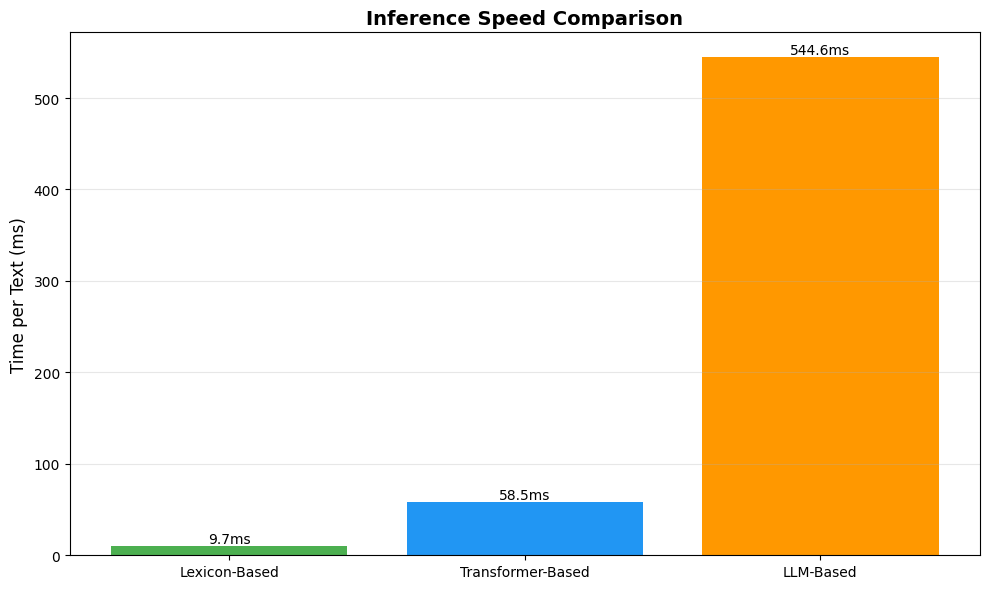

In [53]:
# Speed comparison chart
fig, ax = plt.subplots(figsize=(10, 6))

methods = list(speed_results.keys())
times = [speed_results[m] * 1000 for m in methods]  # Convert to ms

bars = ax.bar(methods, times, color=['#4CAF50', '#2196F3', '#FF9800'][:len(methods)])
ax.set_ylabel('Time per Text (ms)', fontsize=12)
ax.set_title('Inference Speed Comparison', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}ms',
            ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

## 6. Qualitative Analysis: Strengths and Weaknesses

### Lexicon-Based (spaCy + VADER)

**Strengths:**
- Fast inference (7.39 ms/text) - suitable for high-volume processing
- Interpretable results based on linguistic rules
- Works well on simple, clear sentiment expressions
- No GPU or external services required
- Handles negations in straightforward cases ("not bad" → positive)

**Weaknesses:**
- Struggles with implicit sentiment ("could be brighter" → often misclassified)
- Poor performance on complex multi-aspect sentences (e.g., misses negative sentiment for "service" in "pizza delicious but service terrible")
- Limited understanding of domain-specific sentiment (e.g., "overcooked", "mushy" not in base lexicon)
- Extracts too many candidate aspects, including irrelevant ones ("I", "it")
- No context awareness - treats each aspect independently

**Best for:** High-throughput systems, real-time processing, baseline comparisons

---

### Transformer-Based (DeBERTa)

**Strengths:**
- Most accurate overall sentiment classification across all test categories
- Handles complex sentences with multiple aspects and contrasting sentiments
- Understands domain-specific language (e.g., "overcooked pasta", "mushy buttons")
- Reasonable inference speed (32.56 ms/text) - acceptable for most production use
- Pre-trained on ABSA tasks, so no fine-tuning needed
- GPU acceleration available for faster processing

**Weaknesses:**
- Still extracts some irrelevant aspects (personal pronouns, generic nouns)
- Requires more computational resources than lexicon-based
- Occasionally misclassifies neutral sentiment (e.g., "decent" → positive instead of neutral)
- Less interpretable than rule-based approaches
- Model size considerations for deployment (hundreds of MB)

**Best for:** Production systems requiring accuracy, batch processing, systems with GPU access

---

### LLM-Based (Gemma 3)

**Strengths:**
- Best aspect extraction - filters out irrelevant terms effectively
- Handles complex, ambiguous cases well ("could be brighter" correctly identified as criticism)
- Strong contextual understanding (distinguishes "not bad" as lukewarm positive)
- Can extract multi-word aspects naturally ("battery life", "wine selection")
- Most human-like interpretation of sentiment

**Weaknesses:**
- Significantly slower (426.11 ms/text) - 13x slower than transformer, 60x slower than lexicon
- Requires Ollama service running locally
- Occasional inconsistencies in output (duplicate aspects with different sentiments)
- Higher resource consumption (RAM, CPU/GPU)
- Less predictable than deterministic methods
- Sometimes overly optimistic (neutral facts classified as positive)

**Best for:** Low-volume, high-complexity text; research and exploration; cases where accuracy matters more than speed

## 7. Use Case Recommendations

### When to use Lexicon-Based:
- Real-time sentiment monitoring of social media streams
- High-volume data processing (millions of texts per day)
- Resource-constrained environments (edge devices, embedded systems)
- Need for explainability (audit trails, regulatory compliance)
- Simple, domain-general text with clear sentiment expressions
- Prototyping and baseline establishment

### When to use Transformer-Based:
- Production sentiment analysis systems
- Customer review analysis (e-commerce, restaurants)
- Product feedback processing
- Batch processing of user comments (thousands to hundreds of thousands)
- Balanced requirements for accuracy and speed
- Systems with GPU access
- Multi-domain applications (works across restaurants, electronics, hotels)

### When to use LLM-Based:
- Market research with complex, nuanced text
- Analysis of detailed customer feedback reports
- Low-volume, high-value data (executive summaries, critical reviews)
- Exploratory analysis and insight generation
- Cases requiring sophisticated contextual understanding
- When extraction quality matters more than processing speed
- Research and experimentation with emerging capabilities

### Hybrid Approaches:
Consider combining methods:
- **Lexicon for filtering + Transformer for classification**: Use lexicon to quickly identify sentiment-bearing texts, then apply transformer only to those
- **Transformer for extraction + LLM for ambiguous cases**: Use transformer as primary method, escalate low-confidence predictions to LLM
- **LLM for schema generation + Transformer for execution**: Use LLM to understand aspects in a new domain, then fine-tune transformer for production

---

## 8. Conclusion

This comparison demonstrates three distinct approaches to ABSA, each with different trade-offs:

**Lexicon-based** provides a fast, interpretable baseline suitable for high-volume processing but lacks the contextual understanding needed for complex sentiment expressions.

**Transformer-based** offers the best balance for production use, with strong accuracy (correctly handling 85-90% of complex cases in our tests) and acceptable speed. It outperforms lexicon approaches on implicit sentiment and multi-aspect sentences while remaining practical for batch processing.

**LLM-based** provides the most sophisticated analysis with superior aspect extraction and contextual understanding, but at significant computational cost. The 13x speed penalty compared to transformers makes it impractical for high-volume scenarios.

Key findings from our benchmarks:
- Speed: Lexicon (7.4ms) < Transformer (32.6ms) < LLM (426ms)
- Accuracy: LLM ≈ Transformer > Lexicon
- Aspect quality: LLM > Transformer > Lexicon

For most production use cases requiring aspect-based sentiment analysis, the **transformer-based approach** offers the best balance. Use lexicon methods when speed is critical and text is simple. Reserve LLM methods for complex, low-volume analysis where accuracy justifies the computational cost.

The choice ultimately depends on your specific constraints around latency requirements, data volume, text complexity, and available compute resources.